In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(style='whitegrid')
%matplotlib inline

In [21]:
df = pd.read_csv("wrds1.csv", low_memory = False)
#wrds1.csv has only NYSE stocks
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["SICCD"] = pd.to_numeric(df["SICCD"], errors="coerce").astype("Int64")
df.head()

,PERMNO,date,SHRCD,EXCHCD,SICCD,TICKER,COMNAM,NWPERM,PRC,SHROUT,CFACPR,CFACSHR
0,10051,2000-01-03,11,1,3842,HGR,HANGER ORTHOPEDIC GROUP INC,NaN,9.9375,19084.0,1.0,1.0
1,10051,2000-01-04,11,1,3842,HGR,HANGER ORTHOPEDIC GROUP INC,NaN,9.8125,19084.0,1.0,1.0
2,10051,2000-01-05,11,1,3842,HGR,HANGER ORTHOPEDIC GROUP INC,NaN,9.6250,19084.0,1.0,1.0
3,10051,2000-01-06,11,1,3842,HGR,HANGER ORTHOPEDIC GROUP INC,NaN,9.3750,19084.0,1.0,1.0
4,10051,2000-01-07,11,1,3842,HGR,HANGER ORTHOPEDIC GROUP INC,NaN,4.8125,19084.0,1.0,1.0


In [22]:
print(df['EXCHCD'].unique())
print(df['SHRCD'].unique())

[1]
[11]


In [23]:
df.drop(["NWPERM", "SHRCD", "EXCHCD"], axis=1, inplace=True)

In [24]:
df.head()

,PERMNO,date,SICCD,TICKER,COMNAM,PRC,SHROUT,CFACPR,CFACSHR
0,10051,2000-01-03,3842,HGR,HANGER ORTHOPEDIC GROUP INC,9.9375,19084.0,1.0,1.0
1,10051,2000-01-04,3842,HGR,HANGER ORTHOPEDIC GROUP INC,9.8125,19084.0,1.0,1.0
2,10051,2000-01-05,3842,HGR,HANGER ORTHOPEDIC GROUP INC,9.6250,19084.0,1.0,1.0
3,10051,2000-01-06,3842,HGR,HANGER ORTHOPEDIC GROUP INC,9.3750,19084.0,1.0,1.0
4,10051,2000-01-07,3842,HGR,HANGER ORTHOPEDIC GROUP INC,4.8125,19084.0,1.0,1.0


In [25]:
len(df["SICCD"].unique())

794

In [26]:
tickers = [str(i) for i in df['TICKER'].unique()]
tickers.sort()
print(len(tickers))
print("LEH" in tickers)

3522
True


In [27]:
lehman_df = df[df['COMNAM'].str.contains(r'LEHMAN', regex=True, case=False, na=False)]
print(lehman_df.tail())

         PERMNO       date  SICCD TICKER                        COMNAM   PRC  \
5961765   80599 2008-09-11   6282    LEH  LEHMAN BROTHERS HOLDINGS INC  4.22   
5961766   80599 2008-09-12   6282    LEH  LEHMAN BROTHERS HOLDINGS INC  3.65   
5961767   80599 2008-09-15   6282    LEH  LEHMAN BROTHERS HOLDINGS INC  0.21   
5961768   80599 2008-09-16   6282    LEH  LEHMAN BROTHERS HOLDINGS INC  0.30   
5961769   80599 2008-09-17   6282    LEH  LEHMAN BROTHERS HOLDINGS INC  0.13   

           SHROUT  CFACPR  CFACSHR  
5961765  694402.0     1.0      1.0  
5961766  694402.0     1.0      1.0  
5961767  694402.0     1.0      1.0  
5961768  694402.0     1.0      1.0  
5961769  689000.0     1.0      1.0  


In [28]:
price_data = df[["PERMNO", "date", "TICKER", "COMNAM"]].copy()
price_data["price"] = df["PRC"] / df["CFACPR"]
price_data["market_cap"] = (df["SHROUT"] / df["CFACSHR"]) * (df["PRC"] / df["CFACPR"])
price_data["sic2"] = df["SICCD"] // 100
# check the above statement
price_data.columns = [i.lower() for i in price_data.columns]
price_data.head()

,permno,date,ticker,comnam,price,market_cap,sic2
0,10051,2000-01-03,HGR,HANGER ORTHOPEDIC GROUP INC,9.9375,189647.25,38
1,10051,2000-01-04,HGR,HANGER ORTHOPEDIC GROUP INC,9.8125,187261.75,38
2,10051,2000-01-05,HGR,HANGER ORTHOPEDIC GROUP INC,9.6250,183683.50,38
3,10051,2000-01-06,HGR,HANGER ORTHOPEDIC GROUP INC,9.3750,178912.50,38
4,10051,2000-01-07,HGR,HANGER ORTHOPEDIC GROUP INC,4.8125,91841.75,38


In [29]:
company_universe = price_data["ticker"].unique()
print(company_universe)
print(len(company_universe))

['HGR' 'HNGR' 'UCI' ... 'OAS' 'QEP' 'VPG']
3522


In [30]:
random_ticker = random.choice(company_universe)
print(random_ticker)
random_ticker_df = price_data[price_data["ticker"] == random_ticker]
random_ticker_df.tail()

ARLO


,permno,date,ticker,comnam,price,market_cap,sic2
1504751,18013,2024-12-24,ARLO,ARLO TECHNOLOGIES INC,11.54,1157935.14,36
1504752,18013,2024-12-26,ARLO,ARLO TECHNOLOGIES INC,11.77,1181013.57,36
1504753,18013,2024-12-27,ARLO,ARLO TECHNOLOGIES INC,11.47,1150911.27,36
1504754,18013,2024-12-30,ARLO,ARLO TECHNOLOGIES INC,11.25,1128836.25,36
1504755,18013,2024-12-31,ARLO,ARLO TECHNOLOGIES INC,11.19,1122815.79,36


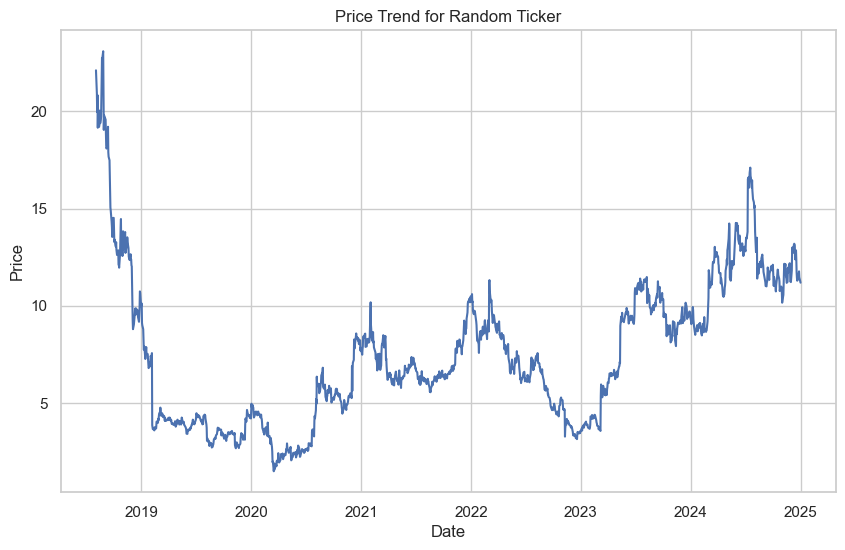

In [31]:
plt.figure(figsize=(10,6))
sns.lineplot(data=random_ticker_df, x="date", y="price")
plt.title("Price Trend for Random Ticker")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [32]:
# listing_info = pd.DataFrame()
price_data.head()

,permno,date,ticker,comnam,price,market_cap,sic2
0,10051,2000-01-03,HGR,HANGER ORTHOPEDIC GROUP INC,9.9375,189647.25,38
1,10051,2000-01-04,HGR,HANGER ORTHOPEDIC GROUP INC,9.8125,187261.75,38
2,10051,2000-01-05,HGR,HANGER ORTHOPEDIC GROUP INC,9.6250,183683.50,38
3,10051,2000-01-06,HGR,HANGER ORTHOPEDIC GROUP INC,9.3750,178912.50,38
4,10051,2000-01-07,HGR,HANGER ORTHOPEDIC GROUP INC,4.8125,91841.75,38


In [33]:
# First and last observation per firm
summary = price_data.groupby("permno")["date"].agg(first_obs="min", last_obs="max").reset_index()

# Define strict boundaries
start_cutoff = pd.Timestamp("2000-01-03")
end_cutoff   = pd.Timestamp("2024-12-31")

# Extract listing/delisting years only for firms strictly inside the boundaries
summary["listing_year"] = summary.loc[summary["first_obs"] > start_cutoff, "first_obs"].dt.year
summary["delisting_year"] = summary.loc[summary["last_obs"] < end_cutoff, "last_obs"].dt.year

# Count listings and delistings per year
years = range(2000, 2025)
listings = summary["listing_year"].value_counts().reindex(years, fill_value=0)
delistings = summary["delisting_year"].value_counts().reindex(years, fill_value=0)

# Combine into a single dataframe
listing_info = pd.DataFrame({"listings": listings, "delistings": delistings})
listing_info["net_change"] = listing_info["listings"] - listing_info["delistings"]
listing_info.index.name = "year"

print(f"Total listings over period: {listing_info["listings"].sum()}")
print(f"Total delistings over period: {listing_info["delistings"].sum()}")
print(f"Net listing change over period: {listing_info["net_change"].sum()}")

listing_info

Total listings over period: 1714
Total delistings over period: 2228
Net listing change over period: -514


,listings,delistings,net_change
year,,,
2000,63,220,-157
2001,77,165,-88
2002,75,99,-24
2003,47,69,-22
2004,67,64,3
2005,63,81,-18
2006,72,85,-13
2007,65,117,-52
2008,50,97,-47


In [34]:
def sector(sic):
    if 1 <= sic <= 9:
        return 'Agri/Fish/Forestry'
    elif 10 <= sic <= 14:
        return 'Mining'
    elif 15 <= sic <= 17:
        return 'Construction'
    elif 20 <= sic <= 39:
        return 'Manufacturing'
    elif 40 <= sic <= 49:
        return 'Transp/Comm/Utilities'
    elif 50 <= sic <= 51:
        return 'Wholesale Trade'
    elif 52 <= sic <= 59:
        return 'Retail Trade'
    elif 60 <= sic <= 67:
        return 'Finance/Insurance/RealEstate'
    elif 70 <= sic <= 89:
        return 'Services'
    elif 91 <= sic <= 99:
        return 'Public Admin / Other'
    else:
        return 'Unknown'